# Classifier Explorer Proof of Concept <a class="tocSkip">
&copy; 2020 by Michael Stanley (Mike.Stanley@ieee.org)<BR>
Last revised: 2 August 2020

# Standard Module Imports

In [22]:
import sklearn
from sklearn import svm, mixture, neighbors, tree, gaussian_process, ensemble, neural_network, naive_bayes, \
    discriminant_analysis, metrics, preprocessing, cluster
import numpy as np
import pandas as pd
import bqplot as bq
import ipywidgets as widgets
from skimage import measure
import scipy.stats as stats
import math
import inspect
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
import traceback

# Sample Size Slider Definition
This sample size slider is replicated in a number of places, so function defined here for simplicity.

In [23]:
def SampleSizeSlider(sampleSize=25, max=500):
    slider = widgets.IntSlider(
        value=sampleSize,
        min=5,
        max=max,
        step=5,
        description='Sample Size:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        layout=widgets.Layout(width='initial'),
        readout=True,
        readout_format='d')
    return(slider)

# SingleDataGenerator
At the bottom of the data generation hierarchy, we have 
a utility function/GUI elements for generation of a single dimension of data.

In [24]:
class SingleDataGenerator(widgets.VBox):
    def __init__(self, label, parent, mean=0):
        self.hidden  = widgets.Layout(display = 'none')
        self.visible = widgets.Layout(visibility = 'visible')
        self.data = []
        self.tdata = []
        self.parent = parent
        self.outdated=True
        self.layout=widgets.Layout(
            display='flex',
            flex_flow='column',
            overflow_x='inherit',
            align_items='flex-start')
        self.name=label
        self.label = widgets.Label(label)
        self.type = widgets.Dropdown(
            options=['Gaussian', 'Bimodal Gaussian', 'Poisson', 'Uniform', 'Exponential'],
            value='Gaussian',
            description='Type:',
            disabled=False,
            layout=widgets.Layout(width='initial')
        )
        self.lam = widgets.FloatSlider(
            value=1.0,
            min=-10.0,
            max=10.0,
            step=0.1,
            description='Lambda:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.mean = widgets.FloatSlider(
            value=mean,
            min=-10.0,
            max=100.0,
            step=0.1,
            description='Mean Value:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.mean2 = widgets.FloatSlider(
            value=2*mean,
            min=-10.0,
            max=100.0,
            step=0.1,
            description='Mean2 Value:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.std = widgets.FloatSlider(
            value=0.20,
            min=0.0,
            max=100.0,
            step=0.1,
            description='StdDev:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.std2 = widgets.FloatSlider(
            value=0.2,
            min=0.0,
            max=100.0,
            step=0.1,
            description='StdDev2:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.loc = widgets.FloatSlider(
            value=0,
            min=-10.0,
            max=10.0,
            step=0.1,
            description='LOC offset:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.scale = widgets.FloatLogSlider(
            value=1,
            min=-1,
            max=3,
            step=0.1,
            description='Scale:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.range=widgets.FloatRangeSlider(
            value=[5, 7.5],
            min=-10.0,
            max=10.0,
            step=0.1,
            description='Range:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.lam = widgets.FloatSlider(
            value=0.1,
            min=0.1,
            max=10.0,
            step=0.1,
            description='Lamba:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )
        self.type.observe(self.type_callback, 'value')
        self.mean.observe(self.callback, 'value')
        self.mean2.observe(self.callback, 'value')
        self.std.observe(self.callback, 'value')
        self.std2.observe(self.callback, 'value')
        self.loc.observe(self.callback, 'value')
        self.lam.observe(self.callback, 'value')
        self.scale.observe(self.callback, 'value')
        self.range.observe(self.callback, 'value')
        super().__init__(
            children = [self.label, self.type, self.range, self.mean, self.std, self.mean2, self.std2, self.lam, self.loc, self.scale]
        )
        self.type_callback('True')
        
    def type_callback(self, dummy):
        if self.type.value=='Gaussian':
            self.mean.layout=self.visible
            self.std.layout=self.visible
            self.mean2.layout=self.hidden
            self.std2.layout=self.hidden
            self.range.layout=self.hidden
            self.lam.layout=self.hidden
            self.loc.layout=self.hidden
            self.scale.layout=self.hidden
        elif self.type.value=='Bimodal Gaussian':
            self.mean.layout=self.visible
            self.std.layout=self.visible
            self.mean2.layout=self.visible
            self.std2.layout=self.visible
            self.range.layout=self.hidden
            self.lam.layout=self.hidden
            self.loc.layout=self.hidden
            self.scale.layout=self.hidden
        elif self.type.value=='Poisson':
            self.mean.layout=self.hidden
            self.std.layout=self.hidden
            self.mean2.layout=self.hidden
            self.std2.layout=self.hidden
            self.range.layout=self.hidden
            self.lam.layout=self.visible
            self.loc.layout=self.hidden
            self.scale.layout=self.hidden
        elif self.type.value=='Uniform':
            self.mean.layout=self.hidden
            self.std.layout=self.hidden
            self.mean2.layout=self.hidden
            self.std2.layout=self.hidden
            self.range.layout=self.visible
            self.lam.layout=self.hidden
            self.loc.layout=self.hidden
            self.scale.layout=self.hidden
        elif self.type.value=='Exponential':
            self.mean.layout=self.hidden
            self.std.layout=self.hidden
            self.mean2.layout=self.hidden
            self.std2.layout=self.hidden
            self.range.layout=self.hidden
            self.lam.layout=self.visible
            self.loc.layout=self.visible
            self.scale.layout=self.hidden
        self.callback(True)
        
    def callback(self, dummy):
        self.outdated = True
        self.parent.parent.callback1('value')
        
    def value(self, dummy, force=False):
        sampleSize = self.parent.sampleSize.value
        numTests = round(1000*self.parent.fraction.value)
        if self.outdated or force:
            if self.type.value=='Gaussian':
                self.data = np.random.normal(loc=self.mean.value, scale=self.std.value, size=sampleSize)
                self.tdata = np.random.normal(loc=self.mean.value, scale=self.std.value, size=numTests)
            elif self.type.value=='Bimodal Gaussian':
                size1 = math.floor(sampleSize/2)
                size2 = sampleSize-size1
                numTests1 = math.floor(numTests/2)
                numTests2 = numTests - numTests1
                data1 = np.random.normal(loc=self.mean.value, scale=self.std.value, size=size1)
                data2 = np.random.normal(loc=self.mean2.value, scale=self.std2.value, size=size2)
                self.data = np.append(data1, data2, axis=0)
                tdata1 = np.random.normal(loc=self.mean.value, scale=self.std.value, size=numTests1)
                tdata2 = np.random.normal(loc=self.mean2.value, scale=self.std2.value, size=numTests2)
                self.tdata = np.append(tdata1, tdata2, axis=0)
                pass
            elif self.type.value=='Poisson':
                self.data = stats.poisson.rvs(mu=self.lam.value, size=sampleSize)
                self.tdata = stats.poisson.rvs(mu=self.lam.value, size=numTests)
            elif self.type.value=='Uniform':
                start=self.range.value[0]
                width=self.range.value[1]-start
                self.data = stats.uniform.rvs(size=sampleSize, loc = start, scale=width)
                self.tdata = stats.uniform.rvs(size=numTests, loc = start, scale=width)
            elif self.type.value=='Exponential':
                self.data = stats.expon.rvs(scale=1/self.lam.value,loc=self.loc.value,size=sampleSize)
                self.tdata = stats.expon.rvs(scale=1/self.lam.value,loc=self.loc.value,size=numTests)
                pass
            else:
                print('NOTHING UPDATED')
            self.outdated = False
        return self.data, self.tdata

        

# ClassDataGenerator
The ClassDataGenerator instantiates two of the SingleDataGenerator objects.  It is used
to generate data for one class of objects.

In [25]:
class ClassDataGenerator(widgets.VBox):
    def __init__(self, parent=None, classNumber=0, sampleSize=50, show=True):
        means = [[0, 0], [.7, .7], [-.7, -.7], [.7, -.7], [-.7, .7]]
        self.hidden  = widgets.Layout(display = 'none')
        self.visible = widgets.Layout(min_width='35%', border='1px solid black', visibility = 'visible', 
                                      overflow_x='hidden')
        super().__init__()
        self.parent = parent
        self.outdated = True
        self.classNumber=classNumber
        self.data = []
        self.tdata = []
        self.results = []
        self.tresults = []
        self.sampleSize = SampleSizeSlider()
        self.fraction = widgets.FloatSlider(
            value=0.5,
            min=0.0,
            max=1.0,
            step=.001,
            description='Pop Fraction:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='f')
        self.name = "Class "+str(self.classNumber) + ' Data Definitions'
        self.title = widgets.Label(self.name)
        self.dgx = SingleDataGenerator('X axis distribution', parent=self, mean=means[classNumber][0])
        self.dgy = SingleDataGenerator('Y axis distribution', parent=self, mean=means[classNumber][1])
        self.children=[self.sampleSize, self.fraction, self.dgx, self.dgy ]
        self.sampleSize.observe(self.callback, 'value')
        if show:
            self.show()
        else:
            self.hide()
    
    def show(self):
        self.layout = self.visible
        
    def hide(self):
        self.layout = self.hidden
        
    def callback(self, dummy):
        self.outdated = True
        self.dgx.outdated = True
        self.dgy.outdated = True
        self.parent.callback1('value')
        
    def value(self, force=False):
        if self.outdated or force:
            x, tx = self.dgx.value(True, force=force)
            y, ty = self.dgy.value(True, force=force)
            self.data = np.column_stack((x, y))
            self.results = self.classNumber*np.ones(self.sampleSize.value)
            
            self.tdata = np.column_stack((tx, ty))
            self.tresults = self.classNumber*np.ones(self.tdata.shape[0])

            return self.data, self.results, self.tdata, self.tresults

# DataGenerator
This is the top level object for data generation.  It instantiates multiple ClassDataGenerator objects.

In [26]:
class DataGenerator(widgets.VBox):
    
    def __init__(self, sampleSize=50):
        super().__init__()
        #self.layout = {
        #    'min_width': '35%',
        #    'border': '1px solid black',
        #}
        self.hidden  = widgets.Layout(display = 'none')
        self.visible = widgets.Layout(min_width='35%', border='1px solid black', visibility = 'visible')
        self.layout = self.visible
        self.name = 'TopDataGenerator'
        self.rejectChildRequests = True
        self.data = []
        self.results = []
        self.tdata = []
        self.tresults = []
        self.classControls=[]
        self.generators = []
        self.numClasses = 2
        self.viewer = None
        self.debug = False
        self.sampleSize = SampleSizeSlider()
        self.sampleSize.observe(self.callback2, 'value')
        self.sampleSize.observe(self.callback1, 'value')
            
        self.numClassesDropdown = widgets.Dropdown(
            options=[('One', 1), ('Two', 2), ('Three', 3), ('Four', 4), ('Five', 5)],
            value=2,
            description='Number of classes:',
            layout=widgets.Layout(width='initial'),
            style={'description_width':'initial'}
        )
        self.numClassesDropdown.observe(self.configureClassGenerators, 'value')
        
        self.regen_button = widgets.Button(
            description='Regenerate',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click me',
            icon=''
        )
        self.regen_button.on_click(self.on_regen_button_clicked)
              
        self.title = widgets.Label("Data Set Generator")
        self.header = widgets.VBox(children=[self.numClassesDropdown, self.sampleSize, self.regen_button])
        self.controls = widgets.Accordion()
        self.createClassGenerators()
        self.children=[self.controls]
        self.rejectChildRequests = False
 
    def hide(self):
        self.layout = self.hidden
    
    def show(self):
        self.layout = self.visible
        
    def hide_pane(self, classNum):
        self.generators[classNum].layout = self.hidden
    
    def show_pane(self, classNum):
        self.generators[classNum].layout = self.visible
        
    def callback1(self, dummy=True):
        if not self.rejectChildRequests:
            self.viewer.update()
    
    def callback2(self, dummy=True):
        self.rejectCR()
        for i in range(self.numClasses): 
            self.generators[i].sampleSize.value = self.sampleSize.value
        self.allowCR()
        
    def rejectCR(self, dummy=True):
        self.rejectChildRequests = True
            
    def allowCR(self, dummy=True):
        self.rejectChildRequests = False
        
    def createClassGenerators(self):
        self.rejectCR()
        apanes=[self.header]
        self.controls.set_title(0, 'Common Stimulus Controls')
        sampleSize = self.sampleSize.value
        self.numClasses = self.numClassesDropdown.value
        self.generators=[]
        for i in range(5):
            cdg = ClassDataGenerator(parent=self, classNumber=i, sampleSize=sampleSize, show=(i<self.numClasses))
            apanes.append(cdg)
            self.generators.append(cdg)
            self.controls.set_title(i+1, "Class "+str(i) + ' Data Definitions')
        self.controls.set_title(6, 'Graph/Analysis Controls')
        self.controls.children = apanes
        self.value()
        if not self.viewer==None:
            self.viewer.update()
            
    def configureClassGenerators(self, value):
        self.rejectCR()
        sampleSize = self.sampleSize.value
        self.numClasses = self.numClassesDropdown.value
        for i in range(5):
            if i<(self.numClasses):
                self.generators[i].show()
                #self.controls.children[i].show()
            else:
                self.generators[i].hide()
                #self.controls.children[i].hide()
        self.callback2()
        self.value()
        if not self.viewer==None:
            self.viewer.update()
        
    def on_regen_button_clicked(self, b):
        self.value(force=True)
        self.viewer.update()
            
    def value(self, force=False):
        self.data=[]
        self.results=[]
        self.tdata=[]
        self.tresults=[]
        #print('numClasses=', self.numClasses)
        for i in range(self.numClasses):
            numPoints=len(self.generators[i].data)
            #print('getting data for class ', i)
            if (i==0):
                self.data, self.results, self.tdata, self.tresults = self.generators[i].value(force=force)
            else:
                d,r,td,tr = self.generators[i].value(force=force)
                self.data = np.concatenate((self.data, d), axis=0)
                self.results = np.concatenate((self.results, r), axis=0 )
                self.tdata = np.concatenate((self.tdata, td), axis=0)
                self.tresults = np.concatenate((self.tresults, tr), axis=0 )
        return self.data, self.results, self.tdata, self.tresults
            
DG = DataGenerator()

# Utility Enumerations

In [27]:
from enum import IntEnum
class CLASSIFIERTYPE(IntEnum):
    KNN = 0
    LINEARSVC = 1
    SVC = 2
    GPC = 3
    DTree = 4
    RForest = 5
    MLP = 6
    AdaBoost = 7
    GaussianNB = 8
    QDA = 9
    GMM = 10
    OCSVM = 11
    KMEANS = 12
    
ClassifierDesc = {}
ClassifierDesc[CLASSIFIERTYPE.KNN] = 'K-Nearest Neighbors'
ClassifierDesc[CLASSIFIERTYPE.SVC] = 'SVC'
ClassifierDesc[CLASSIFIERTYPE.GPC] = 'Gaussian Process'
ClassifierDesc[CLASSIFIERTYPE.DTree] = 'Decision Tree'
ClassifierDesc[CLASSIFIERTYPE.RForest] = 'Random Forest'
ClassifierDesc[CLASSIFIERTYPE.MLP] = 'Multi-Layer Perceptron'
ClassifierDesc[CLASSIFIERTYPE.AdaBoost] = 'AdaBoost'
ClassifierDesc[CLASSIFIERTYPE.GaussianNB] = 'Gaussian Naive-Bayes'
ClassifierDesc[CLASSIFIERTYPE.QDA] = 'Quadratic Discriminant Analysis'
ClassifierDesc[CLASSIFIERTYPE.GMM] = "Gaussian Mixture Model"
ClassifierDesc[CLASSIFIERTYPE.OCSVM] = 'One Class SVM'
ClassifierDesc[CLASSIFIERTYPE.KMEANS] = 'K-Means'

Classifiers = {}
Classifiers[CLASSIFIERTYPE.KNN] = neighbors.KNeighborsClassifier
Classifiers[CLASSIFIERTYPE.SVC] = svm.SVC
Classifiers[CLASSIFIERTYPE.GPC] = gaussian_process.GaussianProcessClassifier
Classifiers[CLASSIFIERTYPE.DTree] = tree.DecisionTreeClassifier
Classifiers[CLASSIFIERTYPE.RForest] = ensemble.RandomForestClassifier
Classifiers[CLASSIFIERTYPE.MLP] = neural_network.MLPClassifier
Classifiers[CLASSIFIERTYPE.AdaBoost] = ensemble.AdaBoostClassifier
Classifiers[CLASSIFIERTYPE.GaussianNB] = naive_bayes.GaussianNB
Classifiers[CLASSIFIERTYPE.QDA] = discriminant_analysis.QuadraticDiscriminantAnalysis
Classifiers[CLASSIFIERTYPE.OCSVM] = svm.OneClassSVM
Classifiers[CLASSIFIERTYPE.GMM] = mixture.GaussianMixture
Classifiers[CLASSIFIERTYPE.OCSVM] = svm.OneClassSVM
Classifiers[CLASSIFIERTYPE.KMEANS] = cluster.KMeans

ClassifierPulldownOptions = [(k, v) for v, k in ClassifierDesc.items()] 

class SCALER(IntEnum):
    NONE = 0
    MINMAX = 1
    ROBUST = 2
    STANDARD = 3

ScalerDesc = {}
ScalerDesc[0] = "None"
ScalerDesc[1] = "MinMax"
ScalerDesc[2] = "Robust"
ScalerDesc[3] = "Standard"

Scalers = [None, preprocessing.MinMaxScaler, preprocessing.RobustScaler, preprocessing.StandardScaler]
Kernels = [ 'rbf', 'linear', 'poly', 'sigmoid']

#for mt in CLASSIFIERTYPE:
#    print(mt)

In [28]:
type(ClassifierDesc)

dict

In [29]:
list(Classifiers)

[<CLASSIFIERTYPE.KNN: 0>,
 <CLASSIFIERTYPE.SVC: 2>,
 <CLASSIFIERTYPE.GPC: 3>,
 <CLASSIFIERTYPE.DTree: 4>,
 <CLASSIFIERTYPE.RForest: 5>,
 <CLASSIFIERTYPE.MLP: 6>,
 <CLASSIFIERTYPE.AdaBoost: 7>,
 <CLASSIFIERTYPE.GaussianNB: 8>,
 <CLASSIFIERTYPE.QDA: 9>,
 <CLASSIFIERTYPE.OCSVM: 11>,
 <CLASSIFIERTYPE.GMM: 10>,
 <CLASSIFIERTYPE.KMEANS: 12>]

In [30]:
list(ClassifierDesc.values())

['K-Nearest Neighbors',
 'SVC',
 'Gaussian Process',
 'Decision Tree',
 'Random Forest',
 'Multi-Layer Perceptron',
 'AdaBoost',
 'Gaussian Naive-Bayes',
 'Quadratic Discriminant Analysis',
 'Gaussian Mixture Model',
 'One Class SVM',
 'K-Means']

In [31]:
Classifiers[CLASSIFIERTYPE.SVC]

sklearn.svm._classes.SVC

# Utility Functions used within the Classifier class

In [32]:
# Convert String to tuple list 
def strToTuple(str):
    res = [] 
    for token in str.split(","): 
        num = int(token) 
        res.append(num) 
    return(tuple(res))

In [33]:
def listToParams(d):
    params='('
    first=True;
    for pair in d:
        if not first:
            params += ', '
        key = str(pair[0]).replace('\'','')
        params += key + '=' + str(pair[1])
        first = False
    params += ')'
    return(params)

# Classifier
This Python class encapsulates the sklear classification calls.

In [34]:
class Classifier():
    def __init__(self, data_source, modelType=CLASSIFIERTYPE.SVC, scalerType=SCALER.NONE, **kwargs):
        self.modelType=modelType
        self.scalerType=scalerType
        self.scaler=None
        self.kwargs = kwargs
        self.cm = None
        self.data_source = data_source
        self.model_params = {}
        self.model_params['kernel']='rbf'
        self.model_params['kernel_object']=1.0*RBF(1.0)
        self.model_params['N']=3
        self.model_params['C']=1.0
        self.model_params['alpha']=0.001
        self.model_params['gamma']=2.0
        self.model_params['nu']=0.2
        self.model_params['max_depth']=5
        self.model_params['n_estimators']=10
        self.model_params['max_features']=2
        self.model_params['max_iter']=5000
        self.model_params['hidden_layer_sizes']='5,5'
        self.model_params['degree']=3
        self.model_params['n_clusters']=2
        self.create_model()
        
    def getModelType(self):
        return(self.modelType)
        
    def setModelType(self, modelType):
        self.modelType=modelType
        
    def getScalerType(self):
        return(self.scalerType)
        
    def setScalerType(self, scalerType):
        self.scalerType=scalerType

    def setModelParam(self, param, value):
        self.model_params[param]=value

    def getModelParam(self, param):
        return(self.model_params[param])
    
    def create_model(self):
        self.kwargs = []
        _kernel = self.model_params['kernel']
        title_prefix=str(self.data_source.numClasses)+'-Class '
        if (self.modelType == CLASSIFIERTYPE.KNN):
            self.model = Classifiers[self.modelType](n_neighbors=self.model_params['N'])
            self.kwargs = [('n_neighbors', self.model_params['N'])]
        elif (self.modelType == CLASSIFIERTYPE.SVC):
            self.model = Classifiers[self.modelType](kernel=self.model_params['kernel'], C=self.model_params['C'])
            self.kwargs = [('kernel', self.model_params['kernel']), ('C', self.model_params['C'])]
        elif (self.modelType == CLASSIFIERTYPE.GPC):
            self.model = Classifiers[self.modelType](kernel=self.model_params['kernel_object'])
            self.kwargs = [('kernel', self.model_params['kernel_object'])]
        elif (self.modelType == CLASSIFIERTYPE.DTree):
            self.model = Classifiers[self.modelType](max_depth=self.model_params['max_depth'])
            self.kwargs = [('max_depth', self.model_params['max_depth'])]
        elif (self.modelType == CLASSIFIERTYPE.RForest):
            self.model = Classifiers[self.modelType](max_depth=self.model_params['max_depth'], 
                n_estimators=self.model_params['n_estimators'],
                max_features=self.model_params['max_features'])
            self.kwargs = [('max_depth', self.model_params['max_depth']),
                          ('n_estimators', self.model_params['n_estimators']),
                          ('max_features', self.model_params['max_features'])]
        elif (self.modelType == CLASSIFIERTYPE.MLP):
            self.model = Classifiers[self.modelType](alpha=self.model_params['alpha'], 
                  hidden_layer_sizes=strToTuple(self.model_params['hidden_layer_sizes']), max_iter=self.model_params['max_iter'])
            self.kwargs = [('alpha', self.model_params['alpha']), 
                           ('hidden_layer_sizes', self.model_params['hidden_layer_sizes']),
                           ('max_iter', self.model_params['max_iter'])]
        elif (self.modelType == CLASSIFIERTYPE.AdaBoost):
            self.model = Classifiers[self.modelType](n_estimators=self.model_params['n_estimators'])
            self.kwargs = [('n_estimators', self.model_params['n_estimators'])]
        elif (self.modelType == CLASSIFIERTYPE.GaussianNB):
            self.model = Classifiers[self.modelType]()
        elif (self.modelType == CLASSIFIERTYPE.QDA):
            self.model = Classifiers[self.modelType]()
        elif (self.modelType == CLASSIFIERTYPE.GMM):
            self.model =  Classifiers[self.modelType](n_components=self.model_params['n_clusters'], covariance_type='full')
            self.kwargs = [('n_clusters', self.model_params['n_clusters']), ('covariance_type', 'full')]
            title_prefix=''
        elif (self.modelType == CLASSIFIERTYPE.KMEANS):
            self.model =  Classifiers[self.modelType](n_clusters=self.model_params['n_clusters'])
            self.kwargs = [('n_clusters', self.model_params['n_clusters'])]
            title_prefix=''
        elif (self.modelType == CLASSIFIERTYPE.OCSVM):
            title_prefix=''
            if _kernel=='poly':
                self.model = Classifiers[self.modelType](kernel=_kernel, degree=self.model_params['degree'], 
                            gamma=self.model_params['gamma'], nu=self.model_params['nu'], 
                            max_iter=self.model_params['max_iter'])
                self.kwargs = [('kernel', self.model_params['kernel']), 
                           ('degree', self.model_params['degree']),
                           ('gamma', self.model_params['gamma']),
                           ('nu', self.model_params['nu']),
                           ('max_iter', self.model_params['max_iter'])]

            elif _kernel=='rbf' or _kernel=='sigmoid':
                self.model = Classifiers[self.modelType](kernel=_kernel, gamma=self.model_params['gamma'], 
                            nu=self.model_params['nu'], max_iter=self.model_params['max_iter'])
                self.kwargs = [('kernel', self.model_params['kernel']), 
                           ('gamma', self.model_params['gamma']),
                           ('nu', self.model_params['nu']),
                           ('max_iter', self.model_params['max_iter'])]
            else:
                self.model = Classifiers[self.modelType](kernel=_kernel,
                            nu=self.model_params['nu'], max_iter=self.model_params['max_iter'])
                self.kwargs = [('kernel', self.model_params['kernel']), 
                           ('nu', self.model_params['nu']),
                           ('max_iter', self.model_params['max_iter'])]            
        args = listToParams(self.kwargs)
        self.title=title_prefix + ClassifierDesc[self.modelType] + ' ' + args
        
    def fit(self, X, Y):
        if self.scalerType==0:
            self.scaler=None
            trainingX = X
        else:
            self.scaler = Scalers[self.scalerType]()
            trainingX = self.scaler.fit_transform(X)
        #print('model=',str(self.model))
        #print('trainingX=', str(trainingX))
        #print('Y=', str(Y))
        if self.modelType == CLASSIFIERTYPE.OCSVM:
            self.model.fit(trainingX)
        else:
            self.model.fit(trainingX, Y)
        
    def test(self, X, Y):
        y_pred = self.predict(X)
        if self.modelType == CLASSIFIERTYPE.OCSVM:
            y_pred = np.ones(len(Y))
        else:
            self.cm = metrics.confusion_matrix(Y, y_pred)
        
    def get_cm(self, X, Y, ax=None):
        names = []
        cases = np.unique(Y)
        for c in np.sort(cases):
            names.append('C'+str(int(c)))
        scaled_X = self.scaleData(X)
        disp = metrics.plot_confusion_matrix(self.model, scaled_X, Y, ax=ax, display_labels=names, cmap=plt.cm.Blues, values_format='n')
        return(disp)
    
    def scaleData(self, x):
        if self.scalerType==SCALER.NONE:
            testX = x
        else:
            testX = self.scaler.transform(x)
        return(testX)
        
    def inverseScaleData(self, x):
        if self.scalerType==SCALER.NONE:
            X = x
        else:
            X = self.scaler.inverse_transform(x, copy=True)
        return(X)
        
    def predict(self, X):
        testX = self.scaleData(X)
        return(self.model.predict(testX))
    
    def classifierName(self):
        return(ClassifierDesc[self.modelType])
    
    def list_args(self):
        for key, value in self.kwargs.items():
            print('{0} = {1}'.format(key, value))
            
#mm = Classifier( modelType=CLASSIFIERTYPE.SVC, kernel='linear')
#mm.__dict__

# GraphView
This class provides the basic graph display.  It is highly dependent upon functions built into
the bqplot plotting library.

In [35]:
def createContourLines(Zmesh, value, x, y, sc_x, sc_y, gridRes, label, color, line_style):
    lines=[]
    contours = measure.find_contours(Zmesh, value)
    x_slope = (x[-1] - x[0]) / (gridRes - 1)
    y_slope = (y[-1] - y[0]) / (gridRes - 1)
    for n, contour in enumerate(contours):
        lbl = label+str(n)
        contour_x = x[0] + contour[:, 1] * x_slope
        contour_y = y[0] + contour[:, 0] * y_slope
        line = bq.Lines(x=contour_x, y=[contour_y], 
                 scales={'x': sc_x, 'y': sc_y},
                 labels=[lbl])
        line.colors=[color]
        line.line_style = line_style
        lines.append(line)
    return(lines)

In [36]:
class GraphView(bq.Figure):

    def __init__(self, data_source):
        super().__init__()
        self.data, self.results, self.tdata, self.tresults = data_source.value()
        self.data_source = data_source
        self.gridRes=200
        self.debug = False
        self.layout = {
            'width' : '600px',
            'height': '600px',
            'border': '1px solid black',
        }
        # start external controls
        self.preserve_db=False
        self.show_contours=True
        self.show_decisionPlane=True
        # end external controls
        self.paddinx_x = 0
        self.padding_y = 0
        self.contours=[]
        self.get_data_set()
        self.sc_x = bq.LinearScale()
        self.sc_y = bq.LinearScale()
        self.size_sc = bq.LinearScale(min=32, max=128)
        self.sc_xc = bq.OrdinalColorScale(colors=['black', 'black', 'black', 'black', 'white'])  
        self.sc_c = bq.OrdinalColorScale(colors=['green', 'blue', '#660066', 'red', 'black'])  #class scale
        self.sc_hc= bq.OrdinalColorScale(colors=['#e6fee6', 'AliceBlue', 'Lavender', 'PaleGoldenRod', 'Gainsboro']) #heatmap colors
        self.sc_o = bq.LinearScale()  #opacity scale
        self.sc_c.min = -1
        self.sc_c.max = 1
        self.sc_o.min = 0
        self.sc_o.max = 1
        self.mm = Classifier(data_source)
        self.mm.fit(self.data, self.results)
        self.mm.test(self.tdata, self.tresults)
        self.default_marker_size=128
        
        self.scat1 = bq.Scatter(x=self.data[:,0], y=self.data[:,1], color=self.results, size=None, \
            scales={'x': self.sc_x, 'y': self.sc_y, 'color': self.sc_c, 'opacity': self.sc_o, 'size': self.size_sc}, \
            default_size=self.default_marker_size, enable_move=True)

        self.update_opacities(self.scat1, self.mm.model, self.sampleSize)

        self.ax_x = bq.Axis(scale=self.sc_x, label='X')
        self.ax_y = bq.Axis(scale=self.sc_y, label='Y', tick_format='0.2f', orientation='vertical')
        self.ax_c = bq.ColorAxis(scale=self.sc_c, label='Class', orientation='vertical', side='right')
        self.marks=[self.scat1]
        self.axes=[self.ax_x, self.ax_y, self.ax_c]
        self.update_line()
        # update line on change of x or y of scatter
        self.scat1.observe(self.update_line, names=['x'])
        #self.scat1.observe(self.update_line, names=['y'])
    
    def reinit(self):
        self.sc_x.min=self.minX
        self.sc_x.max=self.maxX
        self.sc_y.min=self.minY
        self.sc_y.max=self.maxY 
        modelType = self.getModelType()
        classLabel = 'Class'
        if modelType==CLASSIFIERTYPE.OCSVM:
            self.axes=[self.ax_x, self.ax_y]  
            self.scat1 = bq.Scatter(x=self.data[:,0], y=self.data[:,1], colors=['green'], size=None, \
                scales={'x': self.sc_x, 'y': self.sc_y, 'opacity': self.sc_o, 'size': self.size_sc}, \
                default_size=self.default_marker_size, enable_move=True)        
        else:
            self.sc_c = bq.OrdinalColorScale(colors=['green', 'blue', '#660066', 'red', 'black'])  #class scale
            self.sc_c.min = -1
            self.sc_c.max = 1
            self.ax_c = bq.ColorAxis(scale=self.sc_c, label=classLabel, orientation='vertical', side='right')
            self.axes=[self.ax_x, self.ax_y, self.ax_c]
            self.scat1 = bq.Scatter(x=self.data[:,0], y=self.data[:,1], color=self.results, size=None, \
                scales={'x': self.sc_x, 'y': self.sc_y, 'color': self.sc_c, 'opacity': self.sc_o, 'size': self.size_sc}, \
                default_size=self.default_marker_size, enable_move=True)        
        self.scat1.observe(self.update_line, names=['x'])
        #self.scat1.observe(self.update_line, names=['y'])
        
    def update(self):
        if self.debug:
            print('Viewer Update')
            print('  caller name:', inspect.stack()[1][3])
        with self.sc_x.hold_sync():
            with self.sc_y.hold_sync():
                self.get_data_set()
                self.reinit()
                self.update_line()
        
    def get_data_set(self):
        if self.data_source==None:
            self.data = []
            self.results = []
            self.sampleSize=0
            self.minX=0.0
            self.maxX=1.0
            self.minY=0.0
            self.maxY=1.0
        else:
            self.data, self.results, self.tdata, self.tresults = self.data_source.value()
            self.data_source.viewer = self
            self.sampleSize = len(self.results)
            self.minX=self.data[:,0].min()
            self.maxX=self.data[:,0].max()
            self.minY=self.data[:,1].min()
            self.maxY=self.data[:,1].max()
            #print('X= {0:6.4f} to {1:6.4f}, Y = {2:6.4f} to {3:6.4f}'.format(self.minX, self.maxX, self.minY, self.maxY))

    def get_mark_data_set(self, m):
        data = np.column_stack((m.x, m.y))
        results = m.color
        return data,results
    
    def get_mark_data_table(self, m):
        t = np.column_stack((m.x, m.y, m.color))
        return(t)
    
    def save_chart_data_to_csv(self, fn):
        t = self.get_mark_data_table(self.scat1)
        df = pd.DataFrame(t, columns = ['X', 'Y', 'Results'])
        df.to_csv(fn, index=False, float_format='%+e')

    def getModelType(self):
        return(self.mm.getModelType())
    
    def setModelType(self, modelType):
        self.mm.setModelType(modelType)
        # Must always be followed by call to create_model_from_mark_data

    def getScalerType(self):
        return(self.mm.getScalerType())
    
    def setScalerType(self, scalerType):
        self.mm.setScalerType(scalerType)

    def setModelParam(self, name, value):
        self.mm.model_params[name]=value
        # Must always be followed by call to create_model_from_mark_data

    def getModelParam(self, name):
        return(self.mm.model_params[name])

    def create_model_from_mark_data(self, mark_data):
        data, results = self.get_mark_data_set(mark_data)
        self.mm.create_model()
        self.mm.fit(data, results)
        self.mm.test(self.tdata, self.tresults)
        
    def get_cm(self):
        fig, axs = plt.subplots(1, 2, figsize=(16,8))
        data, results = self.get_mark_data_set(self.scat1)
        in_sample=self.mm.get_cm(X=data, Y=results, ax=axs[0])  
        out_of_sample=self.mm.get_cm(X=self.data_source.tdata, Y=self.data_source.tresults, ax=axs[1])
        axs[0].set_title('In-Sample Error')
        axs[1].set_title('Out-of-Sample Error')
        return(fig)
    
    def update_opacities(self, mark, model, sampleSize):
        if hasattr(model, 'support_'):
            opacities = .3*np.ones(sampleSize)
            sizes = 0.5*self.default_marker_size*np.ones(sampleSize)
            sv = model.support_
            for i in sv:
                opacities[i]=1
                sizes[i]=2*sizes[i]
            mark.size=sizes
        else:
            opacities = np.ones(sampleSize)
        mark.opacity=opacities
        
    def update_line(self, change=None):
        global scores
        with self.sc_x.hold_sync():
            with self.sc_y.hold_sync():
                x = np.linspace(min(self.scat1.x), max(self.scat1.x), self.gridRes)
                y = np.linspace(min(self.scat1.y), max(self.scat1.y), self.gridRes)
                Xmesh, Ymesh = np.meshgrid(x, y)
                xy = np.column_stack((Xmesh.ravel(),Ymesh.ravel()))
                self.create_model_from_mark_data(self.scat1)
                self.title= self.mm.title
                self.update_opacities(self.scat1, self.mm.model, self.sampleSize)    
                
                Zmesh = self.mm.predict(xy).reshape(Xmesh.shape)
                #df = self.mm.model.decision_function(xy).reshape(Xmesh.shape)

                heat = bq.HeatMap(x=x, y=y, color=Zmesh, fill_opacities=[0.1], 
                                       scales={'x': self.sc_x, 'y': self.sc_y, 'color': self.sc_hc})
                if self.show_decisionPlane:
                    marks=[heat, self.scat1]
                else:
                    marks=[self.scat1]
                if self.preserve_db:
                    pass # don't clear prior contours
                else:
                    self.contours=[]
                modelType = self.getModelType()
                if modelType==CLASSIFIERTYPE.KMEANS: # Mark centrois
                    scaled_centroids = self.mm.model.cluster_centers_
                    centroids = self.mm.inverseScaleData(scaled_centroids)
                    cenColors = 5*['white']
                    centroid_markers = bq.Scatter(x=centroids[:, 0], y=centroids[:, 1], colors=cenColors, size=None, \
                        scales={'x': self.sc_x, 'y': self.sc_y}, stroke="black", stroke_width=2.0, \
                        default_size=300, marker='circle')        
                    marks.extend([centroid_markers])                    
                    cenColors = 5*['black']
                    centroid_markers = bq.Scatter(x=centroids[:, 0], y=centroids[:, 1], colors=cenColors, size=None, \
                        scales={'x': self.sc_x, 'y': self.sc_y}, \
                        default_size=126, marker='cross')        
                    marks.extend([centroid_markers])                    
                    
                if self.show_contours:
                    if modelType==CLASSIFIERTYPE.GMM:
                        xys = self.mm.scaleData(xy)
                        scores = self.mm.model.score_samples(xys).reshape(Xmesh.shape)
                        mn = scores.min()
                        mx = scores.max()
                        levels = np.linspace(mn, mx, 10)
                        for lvl in levels:
                            new_lines = createContourLines(scores, lvl, x, y, 
                                        self.sc_x, self.sc_y, self.gridRes, 'contour', 'red', 'dashed')
                            self.contours = self.contours + new_lines    
                        for i in range(0, self.data_source.numClasses):
                            new_lines = createContourLines(Zmesh, i+0.5, x, y, 
                                self.sc_x, self.sc_y, self.gridRes, 'contour', 'black', 'solid')
                            self.contours = self.contours + new_lines
                    elif modelType==CLASSIFIERTYPE.SVC and self.data_source.numClasses==2:
                        xys = self.mm.scaleData(xy)
                        df = self.mm.model.decision_function(xys).reshape(Xmesh.shape)
                        new_lines = createContourLines(df, -1.0, x, y, 
                                    self.sc_x, self.sc_y, self.gridRes, 'margin0', 'red', 'dashed')
                        self.contours = self.contours + new_lines
                        new_lines = createContourLines(df, +1.0, x, y, 
                                    self.sc_x, self.sc_y, self.gridRes, 'margin1', 'red', 'dashed')
                        self.contours = self.contours + new_lines
                        new_lines = createContourLines(df, 0.0, x, y, 
                                    self.sc_x, self.sc_y, self.gridRes, 'decisionBoundary', 'black', 'solid')
                        self.contours = self.contours + new_lines
                    else:
                        for i in range(0, self.data_source.numClasses):
                            new_lines = createContourLines(Zmesh, i+0.5, x, y, 
                                    self.sc_x, self.sc_y, self.gridRes, 'contour', 'black', 'solid')
                            self.contours = self.contours + new_lines
                    marks.extend(self.contours)
                self.marks=marks

viewerNoControls = GraphView(DG)

# ClassifierViewerWithControls
This class wraps the Graph view with additional ipywidget controls.

In [37]:
class ClassifierViewerWithControls(widgets.Box):
    def __init__(self, viewer):
        super().__init__()
        self.viewer = viewer
        viewer.data_source.children[0].children+=(self,)
        self.hidden  = widgets.Layout(display = 'none')
        self.visible = widgets.Layout(visibility = 'visible')
    
        # options=[('One', 1), ('Two', 2), ('Three', 3)],

        self.modelTypeWidget = widgets.Dropdown(
            options=ClassifierPulldownOptions,
            value=CLASSIFIERTYPE.SVC,
            description='Classifier:',
            disabled=False,
            layout={'width': 'initial'},
        )
        self.modelTypeWidget.observe(self.changeModelType, 'value')

        self.scalerTypeWidget = widgets.Dropdown(
            options=[('None', 0), ('MinMax', 1), ('Robust', 2), ('Standard', 3)],
            value=0,
            description='Scaler:',
            disabled=False,
            layout={'width': 'initial'},
        )
        self.scalerTypeWidget.observe(self.changeScalerType, 'value')
    
        self.kernelWidget = widgets.Dropdown(
            options=[ 'rbf', 'linear', 'poly', 'sigmoid'],
            value='rbf',
            description='Kernel:',
            disabled=False,
            layout={'width': 'initial'},
        )
        self.kernelWidget.observe(self.changeKernel, 'value')       

        self.N_slider = widgets.IntSlider(
            value=viewer.mm.getModelParam('N'),
            min=3,
            max=15,
            step=2,
            description='KNN Size:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='d')
        self.N_slider.observe(self.changeKNN_N, 'value')

        self.max_depth_slider = widgets.IntSlider(
            value=viewer.mm.getModelParam('max_depth'),
            min=1,
            max=20,
            step=1,
            description='Max Depth:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='d')
        self.max_depth_slider.observe(self.change_max_depth, 'value')

        self.max_iter_slider = widgets.IntSlider(
            value=viewer.mm.getModelParam('max_iter'),
            min=1,
            max=10000,
            step=1,
            description='Max Iter:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='d')
        self.max_iter_slider.observe(self.change_max_iter, 'value')
        
        self.n_estimators_slider = widgets.IntSlider(
            value=viewer.mm.getModelParam('n_estimators'),
            min=1,
            max=20,
            step=1,
            description='# Estimators:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='d')
        self.n_estimators_slider.observe(self.change_n_estimators, 'value')
        
        self.n_clusters_slider = widgets.IntSlider(
            value=viewer.mm.getModelParam('n_clusters'),
            min=1,
            max=20,
            step=1,
            description='# Clusters:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='d')
        self.n_clusters_slider.observe(self.change_n_clusters, 'value')
        
        self.degree_slider = widgets.IntSlider(
            value=viewer.mm.getModelParam('degree'),
            min=1,
            max=10,
            step=1,
            description='Degree:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='d')
        self.degree_slider.observe(self.change_degree, 'value')
        
        self.C_slider = widgets.FloatSlider(
            value=viewer.mm.getModelParam('C'),
            min=0.001,
            max=1000,
            step=.001,
            description='C:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='f')
        self.C_slider.observe(self.changeC, 'value')

        self.alpha_slider = widgets.FloatSlider(
            value=viewer.mm.getModelParam('alpha'),
            min=0.001,
            max=5,
            step=.001,
            description='alpha:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='f')
        self.alpha_slider.observe(self.changeAlpha, 'value')
        
        self.gamma_slider = widgets.FloatSlider(
            value=viewer.mm.getModelParam('gamma'),
            min=0.001,
            max=10,
            step=.001,
            description='gamma:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='f')
        self.gamma_slider.observe(self.changeGamma, 'value')
        
        self.nu_slider = widgets.FloatSlider(
            value=viewer.mm.getModelParam('nu'),
            min=0.001,
            max=1,
            step=.001,
            description='nu:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            layout=widgets.Layout(width='initial'),
            readout=True,
            readout_format='f')
        self.nu_slider.observe(self.changeNu, 'value')

        self.layers = widgets.Text(
            value=viewer.mm.getModelParam('hidden_layer_sizes'),
            description='HL Sizes:',
            disabled=False   
        )
        self.layers.observe(self.changeLayers, 'value')
        
        self.layout=widgets.Layout(
            display='flex',
            flex_flow='column',
            border='solid 2px',
            align_items='flex-start')
        
        self.show_contours = widgets.Checkbox(
            value=True,
            description='Show Contours',
            disabled=False,
            indent=True
        )
        self.show_contours.observe(self.changeShowContours, 'value')
        
        self.preserve = widgets.Checkbox(
            value=False,
            description='Preserve Contours',
            disabled=False,
            indent=True
        )
        self.preserve.observe(self.changePreserveDb, 'value')

        self.show_decisionPlane = widgets.Checkbox(
            value=True,
            description='Show Decision Plane',
            disabled=False,
            indent=True
        )
        self.show_decisionPlane.observe(self.changeShowDecisionPlane, 'value')

        self.download_plot_button = widgets.Button(
            description='Download Plot',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to download a copy of the currently displayed plot',
            icon=''
        )
        self.download_plot_button.on_click(self.on_download_button_clicked)
        
        self.download_dataset_button = widgets.Button(
            description='Download Dataset',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to download a copy of the currently displayed dataset in .csv format',
            icon=''
        )        
        self.download_dataset_button.on_click(self.on_download_dataset_button_clicked)
        
        self.children=[widgets.VBox(children=[self.modelTypeWidget, self.scalerTypeWidget, self.kernelWidget, self.N_slider, 
            self.max_depth_slider, self.n_estimators_slider, self.n_clusters_slider, self.C_slider, 
            self.degree_slider, self.alpha_slider, self.gamma_slider, self.nu_slider, self.max_iter_slider, self.layers,
            self.show_contours, self.preserve, self.show_decisionPlane, self.download_plot_button, self.download_dataset_button])]
        self.setControlVisibity(self.modelTypeWidget.value, self.kernelWidget.value)

    def on_download_dataset_button_clicked(self, b):
        self.viewer.save_chart_data_to_csv('data.csv')
    
    def on_download_button_clicked(self, b):
        self.viewer.save_png()
    
    def setControlVisibity(self, mt, kernel): # mt model type
        self.N_slider.layout = self.hidden
        self.C_slider.layout = self.hidden
        self.kernelWidget.layout=self.hidden
        self.max_depth_slider.layout = self.hidden
        self.max_iter_slider.layout = self.hidden
        self.n_estimators_slider.layout = self.hidden
        self.n_clusters_slider.layout = self.hidden
        self.alpha_slider.layout = self.hidden
        self.gamma_slider.layout = self.hidden
        self.nu_slider.layout = self.hidden
        self.degree_slider.layout = self.hidden
        self.layers.layout = self.hidden
        
        if (mt == CLASSIFIERTYPE.KNN):
            self.N_slider.layout = self.visible
        elif (mt == CLASSIFIERTYPE.SVC):
            self.C_slider.layout = self.visible
            self.kernelWidget.layout = self.visible
        elif (mt == CLASSIFIERTYPE.GPC):
            pass
        elif (mt == CLASSIFIERTYPE.DTree):
            self.max_depth_slider.layout = self.visible
        elif (mt == CLASSIFIERTYPE.RForest):
            self.max_depth_slider.layout = self.visible
            self.n_estimators_slider.layout = self.visible
        elif (mt == CLASSIFIERTYPE.MLP):
            self.alpha_slider.layout = self.visible
            self.layers.layout = self.visible
            self.max_iter_slider.layout = self.visible
        elif (mt == CLASSIFIERTYPE.AdaBoost):
            self.n_estimators_slider.layout = self.visible
        elif (mt == CLASSIFIERTYPE.GaussianNB):
            pass
        elif (mt == CLASSIFIERTYPE.GMM):
            self.n_clusters_slider.layout = self.visible
        elif (mt == CLASSIFIERTYPE.KMEANS):
            self.n_clusters_slider.layout = self.visible
        elif (mt == CLASSIFIERTYPE.QDA):
            pass
        elif (mt == CLASSIFIERTYPE.OCSVM):
            self.kernelWidget.layout = self.visible
            if kernel=='poly':
                self.degree_slider.layout = self.visible
                self.gamma_slider.layout = self.visible
            if kernel=='rbf' or kernel=='sigmoid':
                self.gamma_slider.layout = self.visible
            self.nu_slider.layout = self.visible
            self.max_iter_slider.layout = self.visible
        
    def changeModelType(self, dummy):
        mt = self.modelTypeWidget.value
        kernel =self.viewer.getModelParam('kernel')
        self.viewer.setModelType(mt)
        self.setControlVisibity(mt, kernel) 
        self.n_clusters_slider.value = self.viewer.data_source.numClasses
        self.viewer.update()
        #self.viewer.update_line()
        
    def changeScalerType(self, dummy):
        self.viewer.setScalerType(self.scalerTypeWidget.value)
        self.viewer.update_line()
    
    def changeKernel(self, dummy):
        self.setControlVisibity(self.modelTypeWidget.value, self.kernelWidget.value) 
        self.viewer.setModelParam('kernel', self.kernelWidget.value)
        self.viewer.update_line()
        
    def changeKNN_N(self, dummy):
        self.viewer.setModelParam('N', self.N_slider.value)
        self.viewer.update_line()
        
    def change_max_depth(self, dummy):
        self.viewer.setModelParam('max_depth', self.max_depth_slider.value)
        self.viewer.update_line()

    def change_max_iter(self, dummy):
        self.viewer.setModelParam('max_iter', self.max_iter_slider.value)
        self.viewer.update_line()
        
    def change_n_estimators(self, dummy):
        self.viewer.setModelParam('n_estimators', self.n_estimators_slider.value)
        self.viewer.update_line()
        
    def change_n_clusters(self, dummy):
        self.viewer.setModelParam('n_clusters', self.n_clusters_slider.value)
        self.viewer.update_line()
        
    def change_degree(self, dummy):
        self.viewer.setModelParam('degree', self.degree_slider.value)
        self.viewer.update_line()
        
    def changeC(self, dummy):
        self.viewer.setModelParam('C', self.C_slider.value)
        self.viewer.update_line()
        
    def changeAlpha(self, dummy):
        self.viewer.setModelParam('alpha', self.alpha_slider.value)
        self.viewer.update_line()
        
    def changeGamma(self, dummy):
        self.viewer.setModelParam('gamma', self.gamma_slider.value)
        self.viewer.update_line()

    def changeNu(self, dummy):
        self.viewer.setModelParam('nu', self.nu_slider.value)
        self.viewer.update_line()

    def changeLayers(self, dummy):
        self.viewer.setModelParam('hidden_layer_sizes', self.layers.value)
        self.viewer.update_line()

    def changePreserveDb(self, dummy):
        self.viewer.preserve_db=self.preserve.value
        self.viewer.update_line()

    def changeShowContours(self, dummy):
        self.viewer.show_contours=self.show_contours.value
        self.viewer.update_line()

    def changeShowDecisionPlane(self, dummy):
        self.viewer.show_decisionPlane=self.show_decisionPlane.value
        self.viewer.update_line()

    def confusion_matrix(self):
        return self.viewer.get_cm()
        
viewer = ClassifierViewerWithControls(viewerNoControls)    

# Dashboard
Build the final dashboard, which is comprised of a DataGenerator and SvmViewerWithControls

In [38]:
dashboard=widgets.Box(
    children=[DG, viewer.viewer],
    layout = {
        'border': '1px solid black',
        'width' : '95%'
    }
)

# Display the dashboard

In [39]:
x=['black']
5*x

['black', 'black', 'black', 'black', 'black']

In [40]:
display(dashboard)

Box(children=(DataGenerator(children=(Accordion(children=(VBox(children=(Dropdown(description='Number of class…

# Compute and display a confusion matrix

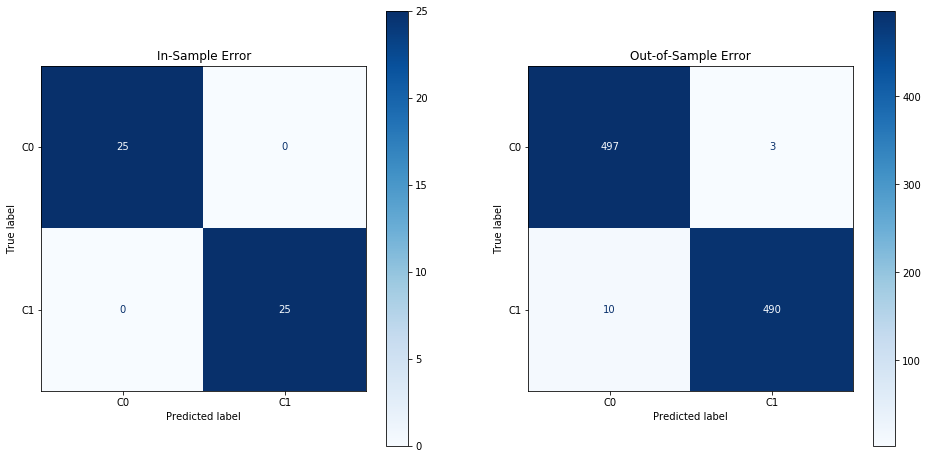

In [41]:
# Re-run this cell any time you want an updated set of confusion matrices from the dashboard above
from sklearn.base import is_classifier
if is_classifier(viewerNoControls.mm.model):
    cm=viewer.confusion_matrix()
else:
    print('KMEANS, GMM and One Class SVM models are not supported for confusion matrices')

In [42]:
is_classifier(mixture.GaussianMixture)

False